## In this script, we will use SAMOSA to sample from the banana distribution

In [1]:
# Some imports
import numpy as np
import sys
import os
from samosa.utils.tools import log_banana
from typing import Any, Dict
import matplotlib.pyplot as plt

/home/sanjan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Lets define the banana model
# The inputs will be the sample (x: np.ndarray of shape (n_dim, n_samples))
# The outputs will be the log posterior (log_posterior: np.ndarray of shape (n_samples,)) or the log likelihood and the log prior
# In this case, we will define the log posterior directly
# Note that other additional quantities like qoi, cost_model_output etc. can be defined

def banana_model(x: np.ndarray) -> Dict[str, Any]:
    """
    Banana model function
    """
    output = {}
    # Just use the log_banana function to compute the log posterior
    log_posterior = log_banana(x)

    output['log_posterior'] = log_posterior

    # If you want to compute the log likelihood and log prior separately, you can do it like this
    # log_likelihood = <Some custom function>(x)
    # log_prior = <Some custom function>(x)
    # output['log_likelihood'] = log_likelihood
    # output['log_prior'] = log_prior

    # If you want to compute the qoi, cost_model_output etc. you can do it like this
    cost = 2
    qoi = np.sum(x, axis=0)

    output['cost'] = cost
    output['qoi'] = qoi

    return output

In [3]:
from samosa.utils.tools import lognormpdf

def Gaussian_model(x: np.ndarray) -> Dict[str, Any]:
    """
    Banana model function
    """
    output = {}

    mu = np.array([[2],[2]])
    sigma = np.array([[1, 0], [0, 1]])

    # Just use the log_banana function to compute the log posterior
    log_posterior = lognormpdf(x, mu, sigma)

    output['log_posterior'] = log_posterior

    cost = 2
    qoi = np.sum(x, axis=0)

    output['cost'] = cost
    output['qoi'] = qoi

    return output

Mean of x: [-5.64598608e-06  9.77423937e-01]
Std of x: [0.9845538  1.72381531]


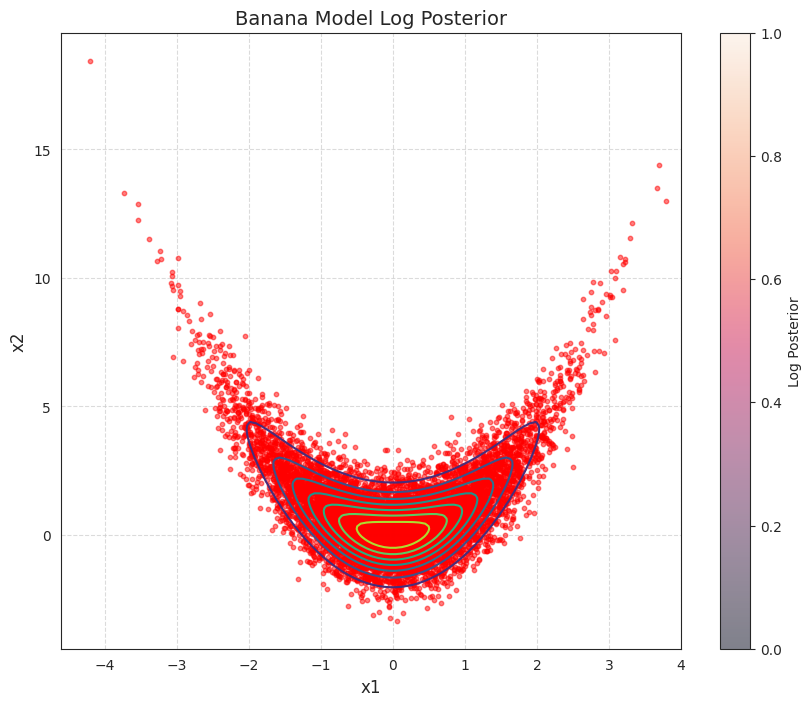

Cost model output: 2
QoI output: [-7.         -6.91919192 -6.83838384 ... 10.83838384 10.91919192
 11.        ]


In [4]:
# Lets plot to see how our banana model looks like
# Define the grid
x1 = np.linspace(-4, 4, 100)
x2 = np.linspace(-3, 7, 100)
X1, X2 = np.meshgrid(x1, x2)

# Define the inputs
x = np.vstack([X1.ravel(), X2.ravel()])

# Compute the log posterior
output = banana_model(x)
# output = Gaussian_model(x)

# Reshape the output
log_posterior = output['log_posterior'].reshape(X1.shape)
log_posterior = np.exp(log_posterior)  # Convert log posterior to posterior

# Plot the log posterior using seaborn
plt.figure(figsize=(10, 8))
import seaborn as sns
sns.set_style("white")

num_points = 10000
r = np.random.randn(2, num_points)
x1 = r[0]
x2 = r[1] + r[0]**2
xscatter = np.vstack([x1,x2])

print('Mean of x:', np.mean(xscatter, axis=1))
print('Std of x:', np.std(xscatter, axis=1))

# Create contour plot with fewer levels and no fill
sns.kdeplot(x=None, y=None, fill=False, levels=7, cmap="viridis", linewidths=1.5)

# Since kdeplot expects data to fit a distribution, we need to use plt.contour directly
plt.contour(X1, X2, log_posterior, levels=7, cmap="viridis", linewidths=1.5)

# Add scatter points
plt.scatter(xscatter[0], xscatter[1], color='red', s=10, alpha=0.5, label='Sample Points')

plt.colorbar(label='Log Posterior')
plt.title('Banana Model Log Posterior', fontsize=14)
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Print output
print("Cost model output:", output['cost'])
print("QoI output:", output['qoi'])


Sampling in Samosa is done by using the base MCMC sampler class
This sampler works by using different components:

- A model 

- A Kernel (Metropolis-Hastings and Delayed Rejection)

- A Proposal (Gaussian random walk, Independent Gaussian proposal)
    - Adapters (Haario's adapter and Andrieu's global adapter)

The kernel does not inherit from the propsal - this is done to mix and match different proposals with different kernels. 

For example, if you want to use the DRAM sampler, you would do something like

kernel = DelayedRejectionKernel(model, cov_scale)

proposal = GaussianRandomWalk(mu, sigma)

adapter = HaarioAdapter(scale, adapt_start, adapt_end)

adaptive_proposal = AdaptiveProposal(proposal, adapter)

Finally build the sampler:

sampler = MCMCsampler(model, kernel, adaptive_proposal, initial_position, n_iterations)
sampler.run(output_dir)

Acceptance rate: 0.24676
Positions shape: (2, 37500)
Mean of the samples: [-0.00742221  1.00420088]
Standard deviation of the samples: [1.00078131 1.69522859]


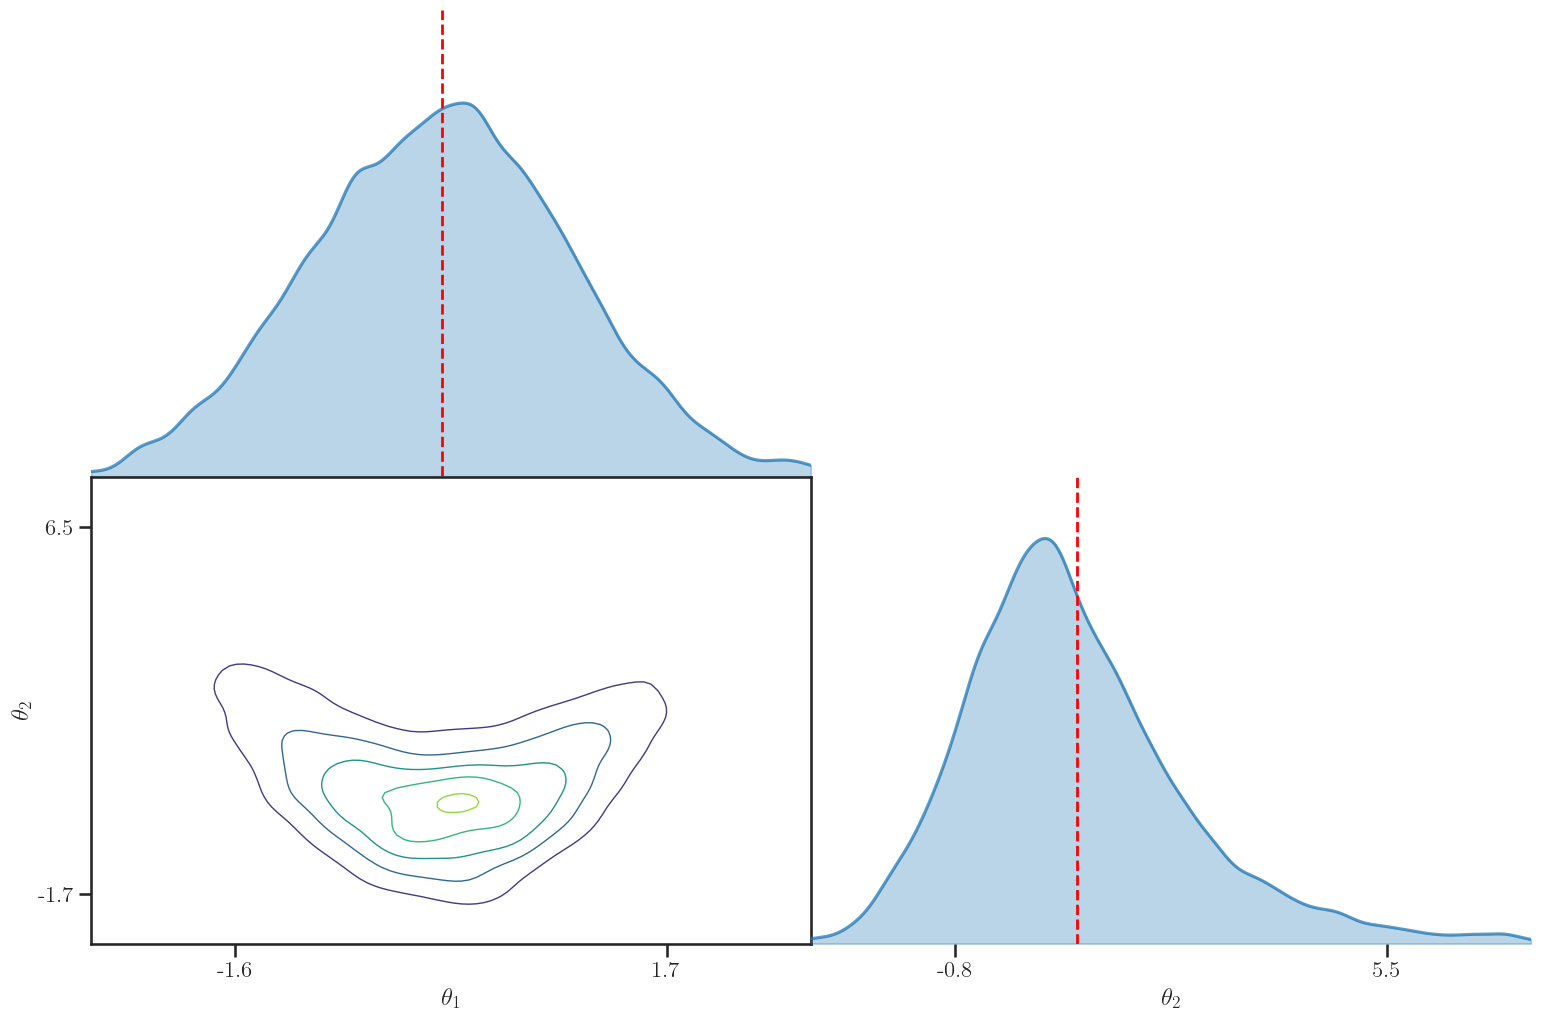

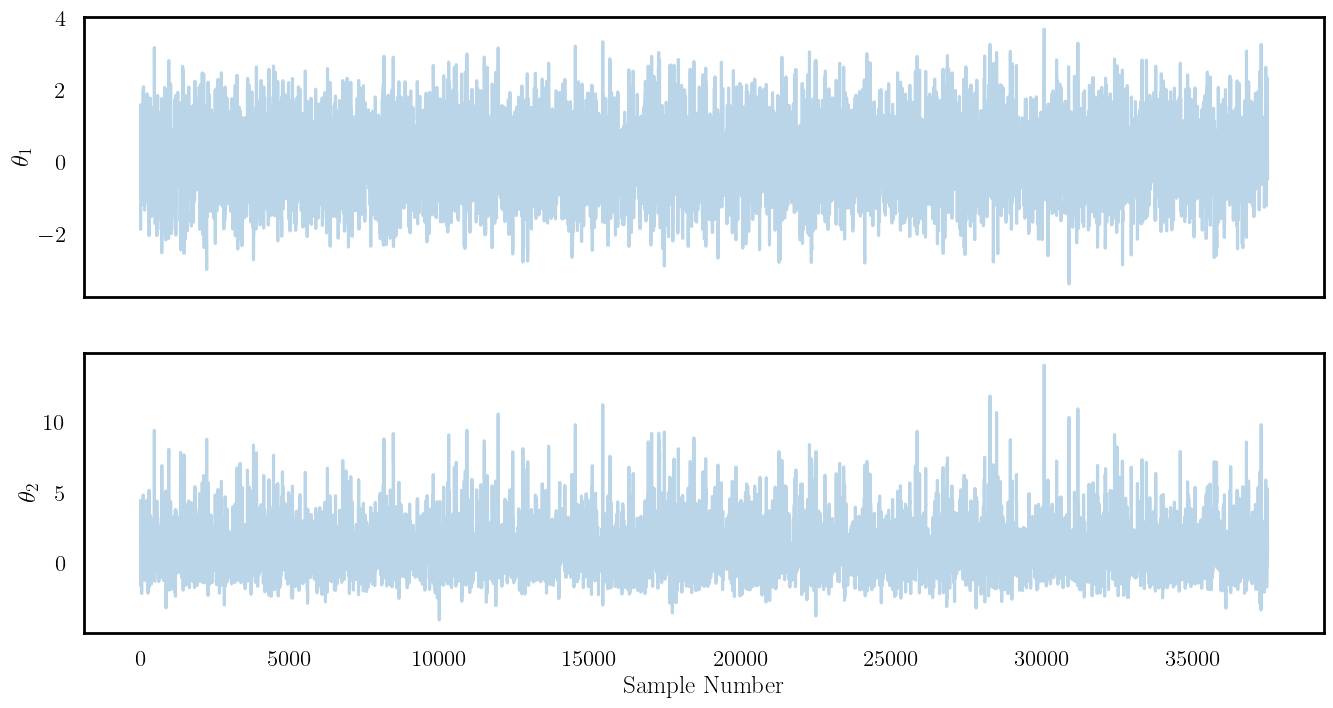

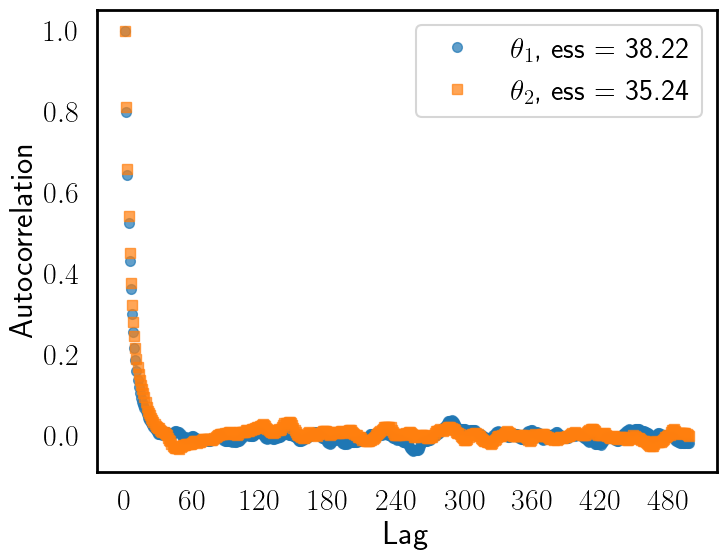

In [5]:
# Lets mix and match some kernels and proposals and run MCMC

# This is just a simple example of how to use the samosa package
from samosa.kernels.metropolis import MetropolisHastingsKernel
from samosa.kernels.delayedrejection import DelayedRejectionKernel
from samosa.proposals.gaussianproposal import GaussianRandomWalk, IndependentProposal
from samosa.proposals.adapters import HaarioAdapter, GlobalAdapter
from samosa.core.proposal import AdaptiveProposal

from samosa.samplers.single_chain import MCMCsampler

from samosa.utils.post_processing import get_position_from_states

# Define the proposal
proposal = GaussianRandomWalk(mu=np.zeros((2,1)), sigma=np.eye(2))
# proposal = IndependentProposal(mu=np.zeros((2,1)), sigma=2.38**2/2*np.eye(2))
# adapter = HaarioAdapter(scale=2.38**2/2)
adapter = GlobalAdapter(ar=0.234, adapt_start=1000, adapt_end=10000)
adaptive_proposal = AdaptiveProposal(proposal, adapter)

model = banana_model
# model = Gaussian_model

# Define the kernel
# kernel = MetropolisHastingsKernel(model)
kernel = DelayedRejectionKernel(model, cov_scale=0.5)

sampler = MCMCsampler(model, kernel, adaptive_proposal, initial_position=np.zeros((2, 1)), n_iterations=50000) 
ar = sampler.run('banana')

print("Acceptance rate:", ar)

# Load samples from the output directory
samples = sampler.load_samples('banana')

# Get the positions of the samples
burnin = 0.25
positions = get_position_from_states(samples, burnin)
print("Positions shape:", positions.shape)

print("Mean of the samples:", np.mean(positions, axis=1))
print("Standard deviation of the samples:", np.std(positions, axis=1))

# Plot the scatter plot of the samples
from samosa.utils.post_processing import scatter_matrix, plot_trace, plot_lag
fig, _, _ = scatter_matrix([positions])
plt.show()

# Plot the trace of the samples
fig, _ = plot_trace(positions)
plt.show()

# Plot the lag of the samples
fig, _ = plot_lag(positions)
plt.show()